## Intro

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt 

In [2]:
torch.__version__

'1.8.0'

In [3]:
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data/mnist_train', train=True, transform= transforms.ToTensor(), download=True)

In [5]:
test_dataset = torchvision.datasets.MNIST(root='./data/mnist_train', train=False, transform= transforms.ToTensor())

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

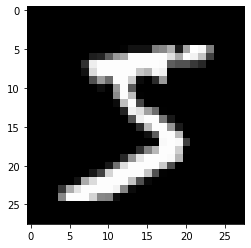

In [8]:
img = train_dataset.data[0]
plt.imshow(img, cmap='gray')

In [9]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
class Dataset_train(Dataset):
    def __init__(self, data):
        self.data = data.data
        self.target = data.targets
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    
    def __len__(self):
        return self.data.shape[0]

In [11]:
train_d = Dataset_train(train_dataset)
test_d = Dataset_train(test_dataset)

In [12]:
loader_train = DataLoader(dataset=train_d, batch_size=1000, shuffle= True) # [tensor of images, tensor of labels]

loader_test = DataLoader(dataset=test_d, batch_size=100, shuffle= False)

## Build and Train Network

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #batch size is [1000, 1, 28, 28], Net input is [1000, 28*28]
        #self.flat = nn.Flatten()
        self.L1 = nn.Linear(28*28, 1000)
        self.relu = nn.ReLU()
        self.L2 = nn.Linear(1000,200)
        self.L3 = nn.Linear(200,10)
    
    def forward(self, input):
        input = input.reshape(-1, 28*28).float()
        out = self.L1(input)
        out = self.relu(out)
        out = self.L2(out)
        out = self.relu(out)
        out = self.L3(out)
        return out

In [21]:
network = Net()

In [22]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=network.parameters(), lr= 0.001)

In [23]:
# Training Loop

#parametres
num_epoch = 10

for epoch in range(num_epoch):

    for i, (inputs, targets) in enumerate(loader_train):
        
        pred = network(inputs)

        loss = loss_fn(pred, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 25 == 0: 
            print(f'epoch: {epoch+1}/{num_epoch} , iteration: {i}, Loss: {loss: .4f}')
    # test network
    with torch.no_grad():
        pred_test = network(test_dataset.data)
        loss_test = loss_fn(pred_test, test_dataset.targets)
        print(f'******* Test Loss ******** : {loss_test:.4f}')


epoch: 1/10 , iteration: 0, Loss:  11.8055
epoch: 1/10 , iteration: 25, Loss:  0.4974
epoch: 1/10 , iteration: 50, Loss:  0.2831
******* Test Loss ******** : 0.2163
epoch: 2/10 , iteration: 0, Loss:  0.2114
epoch: 2/10 , iteration: 25, Loss:  0.2086
epoch: 2/10 , iteration: 50, Loss:  0.1386
******* Test Loss ******** : 0.1472
epoch: 3/10 , iteration: 0, Loss:  0.1301
epoch: 3/10 , iteration: 25, Loss:  0.1152
epoch: 3/10 , iteration: 50, Loss:  0.1037
******* Test Loss ******** : 0.1141
epoch: 4/10 , iteration: 0, Loss:  0.0782
epoch: 4/10 , iteration: 25, Loss:  0.0582
epoch: 4/10 , iteration: 50, Loss:  0.0528
******* Test Loss ******** : 0.0966
epoch: 5/10 , iteration: 0, Loss:  0.0521
epoch: 5/10 , iteration: 25, Loss:  0.0782
epoch: 5/10 , iteration: 50, Loss:  0.0608
******* Test Loss ******** : 0.0949
epoch: 6/10 , iteration: 0, Loss:  0.0374
epoch: 6/10 , iteration: 25, Loss:  0.0335
epoch: 6/10 , iteration: 50, Loss:  0.0412
******* Test Loss ******** : 0.0932
epoch: 7/10 , i

## Final Accuracy Test

In [24]:
num_samples = 0
num_correct = 0
incorrects = []

for image, label in loader_test:
    pred_final = network(image)
    preddicted_numbers = torch.argmax(pred_final, dim= 1)

    if num_correct != num_samples:
        for k in range(len(label)):
            if preddicted_numbers[k] != label[k]:
                incorrects.append((preddicted_numbers[k], label[k], num_samples+k))

    num_correct += (preddicted_numbers == label).sum().item()
    num_samples += len(image)

print(f'The Accuracy of model is: %{(num_correct / num_samples)*100 : .2f}')

The Accuracy of model is: % 97.69


Number of incorrect answers: 229
(tensor(5), tensor(6), 217)


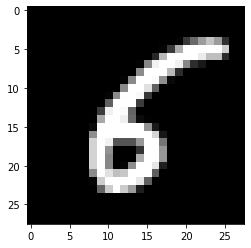

In [25]:
# sample of incorrect predictions
print(f'Number of incorrect answers: {len(incorrects)}')
print(incorrects[0])
plt.imshow(test_dataset[incorrects[0][2]][0].view(28,28), cmap='gray')

## Test Network with new Data

In [46]:
#make new images by transforming test image
import torchvision.transforms.functional as TF

for ang in range(0,75,5):
    img_edit = TF.rotate(test_dataset.data[0].view(1,1,28,28), angle=ang)

    img = test_dataset.data[0]
    #plt.imshow(img, cmap='gray')
    #plt.imshow(img_edit.view(28,28), cmap='gray')

    guessed = network(img_edit)
    print(torch.argmax(guessed), ang)

    print(guessed)

tensor(7) 0
tensor([[  0.4268,  -4.1852,   6.9406,   8.5702,  -3.5742,  -2.3580, -10.9973,
          22.0824,   1.5769,   1.3610]], grad_fn=<AddmmBackward>)
tensor(7) 5
tensor([[ -2.9815,  -3.6199,   4.8975,   7.5513,  -2.6344,  -1.4721, -12.3274,
          22.7487,   3.1714,   3.2631]], grad_fn=<AddmmBackward>)
tensor(7) 10
tensor([[ -3.5580,  -3.4600,   5.4765,   9.1413,  -4.9662,  -0.8679, -12.8093,
          21.1249,   3.1072,   5.6464]], grad_fn=<AddmmBackward>)
tensor(7) 15
tensor([[ -6.9511,  -3.8696,   2.9005,   7.9181,  -6.6034,   0.6049, -12.4175,
          23.2461,   2.2461,   8.0330]], grad_fn=<AddmmBackward>)
tensor(7) 20
tensor([[ -5.6333,  -4.8276,   2.1759,   6.9099,  -7.0224,   1.1303, -12.1639,
          20.7567,  -0.1047,   6.2899]], grad_fn=<AddmmBackward>)
tensor(7) 25
tensor([[-6.2059, -4.1155, -0.8017,  1.4986, -4.3421,  1.9458, -8.0547, 15.5518,
         -2.0430,  5.3066]], grad_fn=<AddmmBackward>)
tensor(7) 30
tensor([[-4.8595, -2.5080, -0.9641, -0.2189, -0.287

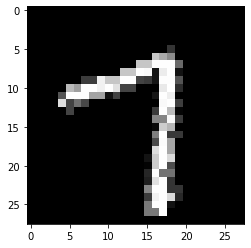

tensor(7)

tensor([[-6.2059, -4.1155, -0.8017,  1.4986, -4.3421,  1.9458, -8.0547, 15.5518,
         -2.0430,  5.3066]], grad_fn=<AddmmBackward>)